In [1]:
import zipfile
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import timeit

import pandas as pd
import pickle
import cv2
import skimage.morphology as morp
from skimage.filters import rank
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import tensorflow as tf
from tensorflow.keras.regularizers import L2
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

# Outline
* [Download Data](#Download-Data)
* [Data Exploration](#Data-Exploration)
* [Data Preprocessing](#Data-Preprocessing)

## Download Data
- Download data ffrom the repo
- Unzip the data from dataroot folder (with dataroot as the folder default)
- read in sign names from csv file

In [2]:
def unzip_traffic_signs(directory='dataroot/'):
    """
    Unzips traffic sign files from a specified directory.

    Args:
        directory (str): The directory path where the traffic sign files are located. 
                         Defaults to 'dataroot/'.

    Raises:
        Exception: If an error occurs during the unzipping process, the exception is printed.

    Returns:
        None: The function does not return any value.
    """
    try:
        for file in os.listdir(directory):
            print(file)
            if file.endswith('.zip'):
                print('Unzipping ' + file)
                with zipfile.ZipFile(directory + file, 'r') as zip_ref:
                    print('Extracting ' + file)
                    zip_ref.extractall(directory)
    except Exception as e:
        print(e)

In [3]:
def download_traffic_signs(directory='dataroot/', unzip_data=False, data_zip_link=[
    'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip',
    'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip',
    'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip'
]):
    """
    Downloads traffic sign data from specified links and optionally unzips the data files.

    Args:
        directory (str): The directory path where the data files will be downloaded. 
                        Defaults to 'dataroot/'.
        unzip_data (bool): Whether to unzip the downloaded data files or not. 
                        Defaults to False.
        data_zip_link (list): A list of URLs pointing to the data zip files. 
                            Defaults to a list of three URLs.

    Raises:
        Exception: If an error occurs during the downloading or unzipping process, the exception is printed.

    Returns:
        None: The function does not return any value.
    """
    try:
        !mkdir $directory
        try:
            for link in data_zip_link:
                !wget -P $directory $link
                print(f"Data file {link} downloaded")
            if unzip_data:
                unzip_traffic_signs(directory)
        except Exception as e:
            print('Error downloading data')
            print(e)
    except Exception as e:
        print('Error making directory')
        print(e)    

In [4]:
def download_traffic_names(sign_name_url ="https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv"):
    """
    Downloads traffic sign names from a specified URL.

    Args:
        sign_name_url (str): The URL pointing to the sign names file. 
                            Defaults to a URL pointing to a CSV file.

    Raises:
        Exception: If an error occurs during the downloading process, the exception is printed.

    Returns:
        None: The function does not return any value.
    """
    try:
        df = pd.read_csv(sign_name_url)
        signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
        return signnames    
    except Exception as e:
        print('Error downloading sign names')
        print(e)

In [5]:
def load_traffic_images(directory='dataroot/'):
    """
    Loads traffic sign images from a specified directory.

    Args:
        directory (str): The directory path where the traffic sign files are located.
                        Defaults to 'dataroot/'.
                        
    Raises:
        Exception: If an error occurs during the loading process, the exception is printed.

    Returns:
        list: A list of traffic sign images.    
    """
    signimages = []
    try:
        for file in os.listdir(directory):
            if file.endswith('.p'):
                signimages.append(pickle.load(open(directory + file, 'rb')))
        return signimages
    except Exception as e:
        print('Error loading images')
        print(e)

In [6]:
train, valid, test = load_traffic_images(directory='dataroot/')
signnames = download_traffic_names()

## Data Exploration
- Look and sign image name keys
- Get shape of training, validation and test data
- Plot a sample of the images
- Pixel intensity distribution
- Plot a histogram of the number of images per class

In [7]:
print("Sign Names: ", signnames.values())

Sign Names:  dict_values(['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 

In [8]:
print("Key Values: ", train.keys())

Key Values:  dict_keys(['sizes', 'coords', 'features', 'labels'])


In [9]:
train_images, train_labels = train['features'], train['labels']
valid_images, valid_labels = valid['features'], valid['labels']
test_images, test_labels = test['features'], test['labels']

The dict_keys are `coords`, `labels`, `features`, and `sizes`.
* `sizes`: This is a tuple (width, height) containing the original width and height of each image.
* `coords`: This is the coordinates of a bounding box around the sign in the image.
* `features`: This is a 4D array containing the actual image data. Images are represented as arrays of pixel values. This key is what we will be using for image analysis and model training. (num examples, width, height, channels (RGB))) 
* `labels`: This contains the labels (one-hot-encoded) associated with each image. This is what we will be using for model training and evaluation.

In [10]:
print("Shape of features: ", train['features'].shape)
print("Shape of labels: ", train['labels'].shape)
print("Shape of sizes: ", train['sizes'].shape)

Shape of features:  (12630, 32, 32, 3)
Shape of labels:  (12630,)
Shape of sizes:  (12630, 2)


In [11]:
print("Number of training examples: ", train_images.shape[0])
print("Number of validation examples: ", valid_images.shape[0])
print("Number of testing examples: ", test_images.shape[0])

Number of training examples:  12630
Number of validation examples:  34799
Number of testing examples:  4410


In [12]:
print("Image data shape: ", train_images[0].shape)
print("Number of classes: ", len(np.unique(train_labels)))

Image data shape:  (32, 32, 3)
Number of classes:  43


In [13]:
def plot_image(images, labels, signnames, index, cmap=None):
    """
    Plots a traffic sign image.

    Args:
        image_dict (dict): A dictionary containing traffic sign images.
        index (int): The index of the image to plot.
    """
    image = images[index]
    plt.imshow(image, cmap=cmap)
    plt.title(f'{labels[index]} = {signnames[labels[index]]}')
    plt.show()

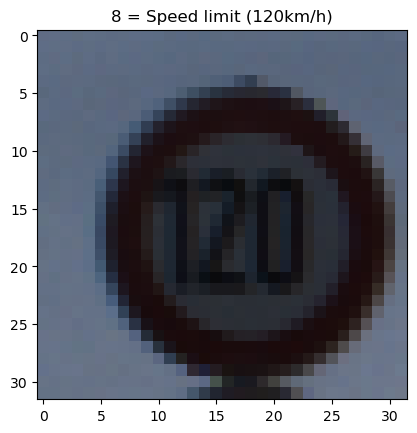

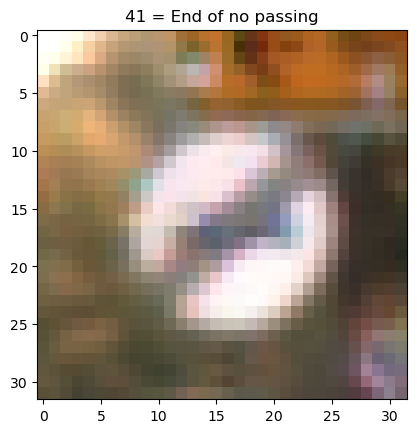

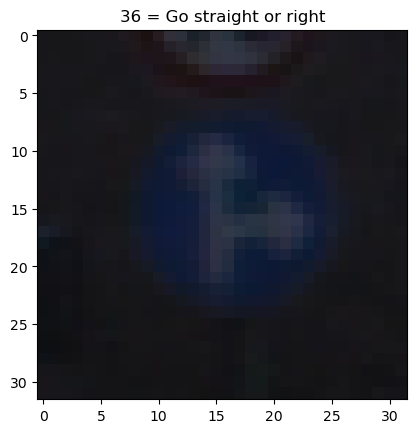

In [14]:
plot_image(train_images, train_labels, signnames, 123)
plot_image(valid_images, valid_labels, signnames, 123)
plot_image(test_images, test_labels, signnames, 123)

In [15]:
def plot_all_signs(images, labels, signnames, cmap=None):

    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    num_cols = 4
    num_rows = (num_labels - 1) // num_cols + 1

    fig = plt.figure(figsize=(20, 16))

    for i, label in enumerate(unique_labels, 1):
        image = images[labels == label][0]
        ax = fig.add_subplot(num_rows, num_cols, i)
        ax.imshow(image, cmap=cmap)
        ax.set_title(f'{label} = {signnames[label]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

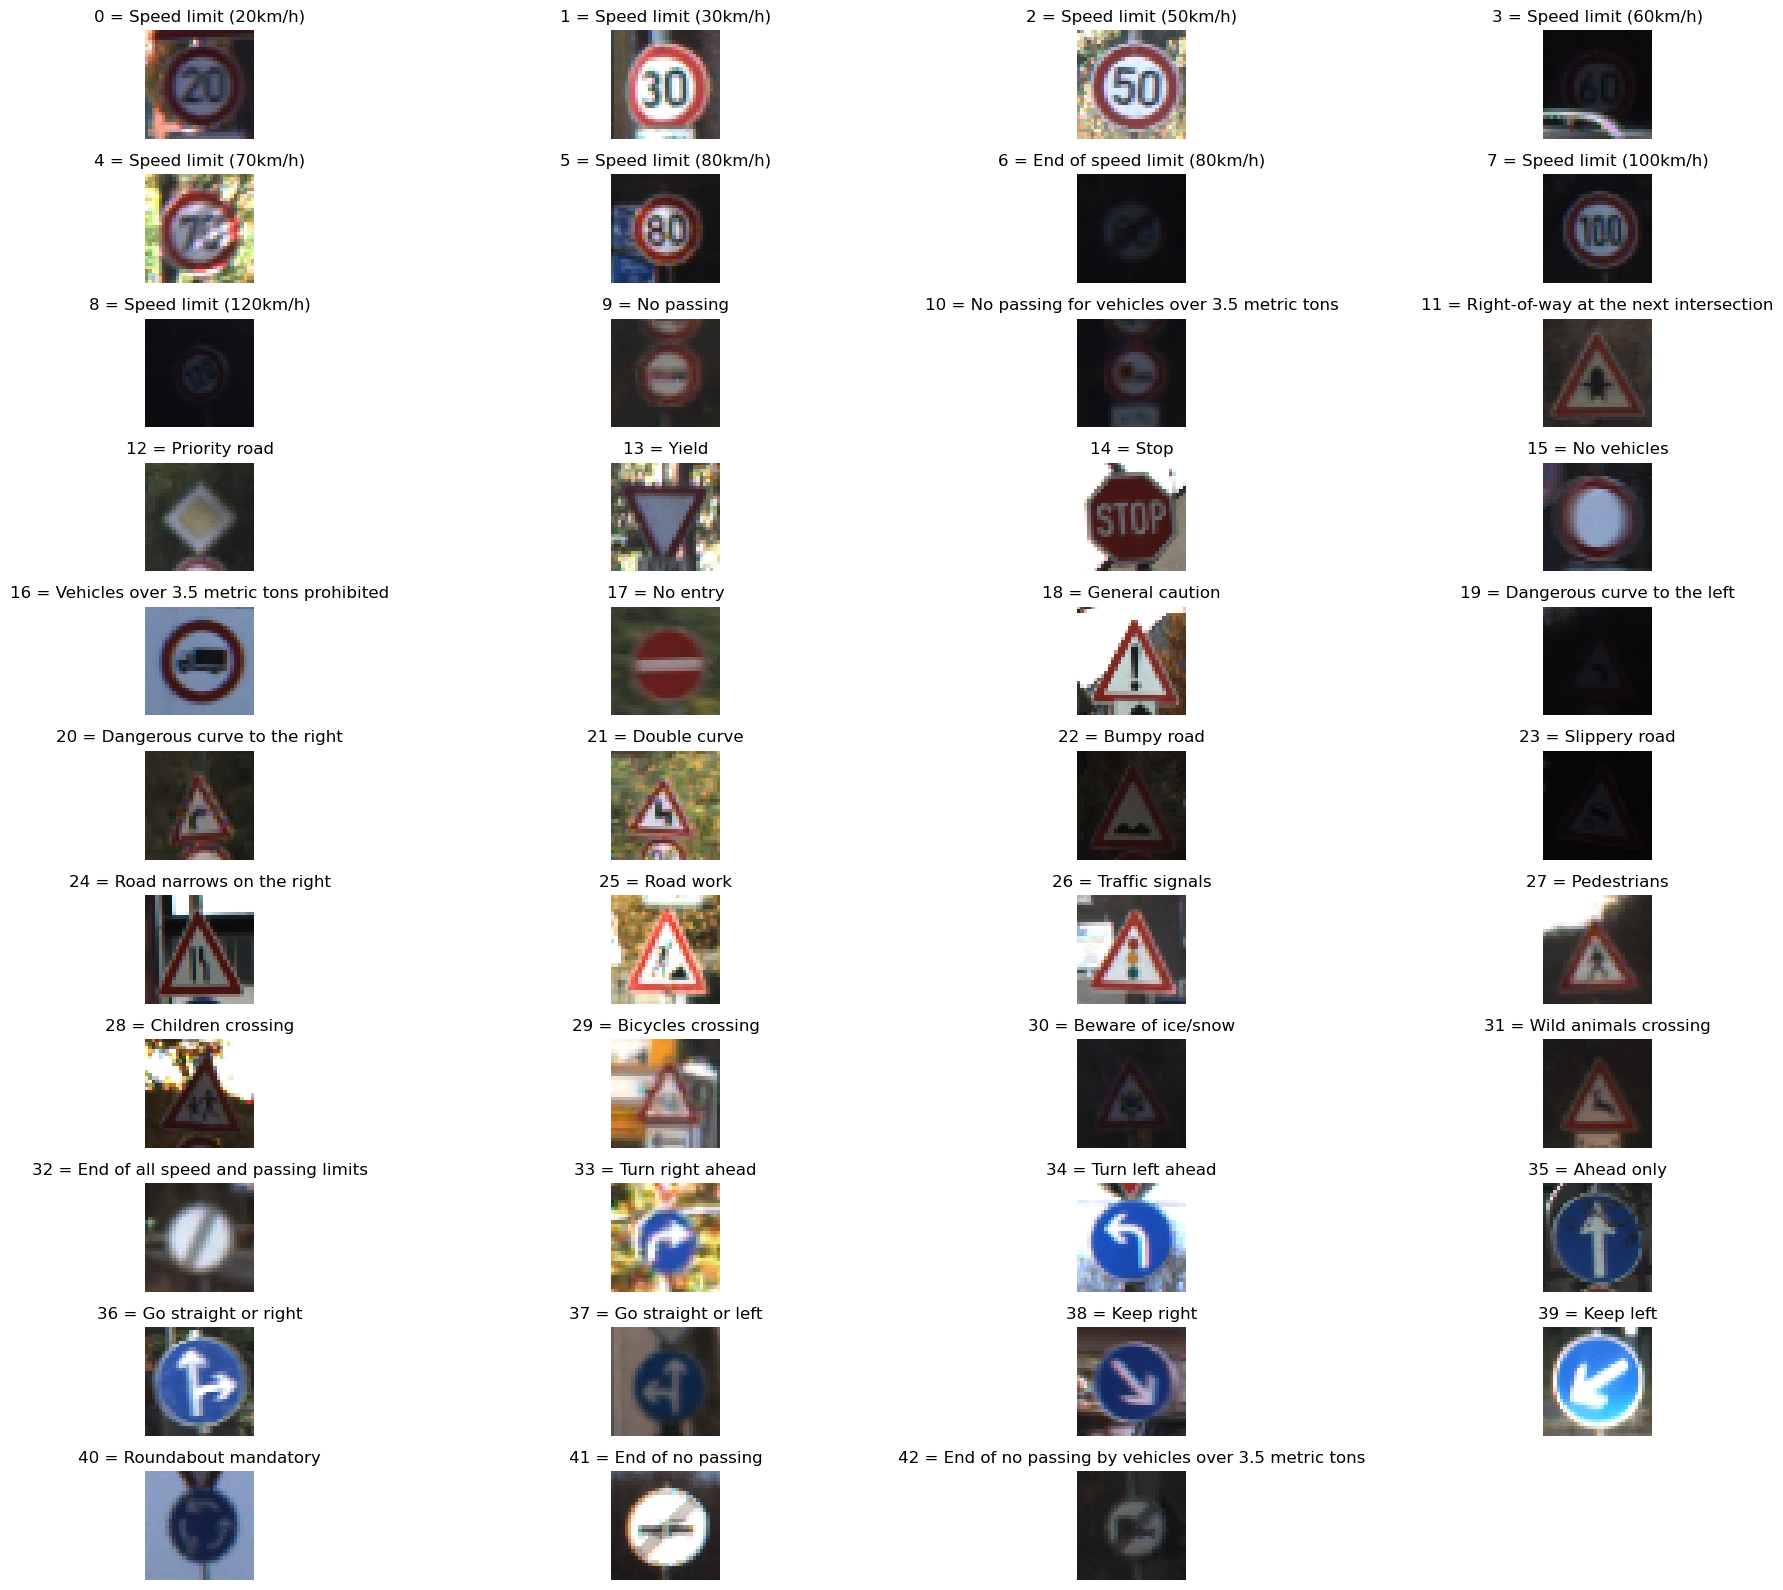

In [16]:
plot_all_signs(train_images, train_labels, signnames)

In [17]:
def plot_pixel_distribution(images, labels, signnames, selected_labels=None):
    
    unique_labels = np.unique(labels)

    if selected_labels is not None:
        unique_labels = unique_labels[selected_labels]

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        label_images = images[label_indices]

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot pixel distribution
        pixel_values = label_images.flatten()
        axes[0].hist(pixel_values, bins=256, color='gray', alpha=0.7)
        axes[0].set_title(f"Pixel Distribution - {signnames[label]}")
        axes[0].set_xlabel('Pixel Intensity')
        axes[0].set_ylabel('Frequency')

        # Plot box and whisker plot
        axes[1].boxplot(pixel_values)
        axes[1].set_title(f"Box and Whisker Plot - {signnames[label]}")
        axes[1].set_ylabel('Pixel Intensity')

        plt.tight_layout()
        plt.show()



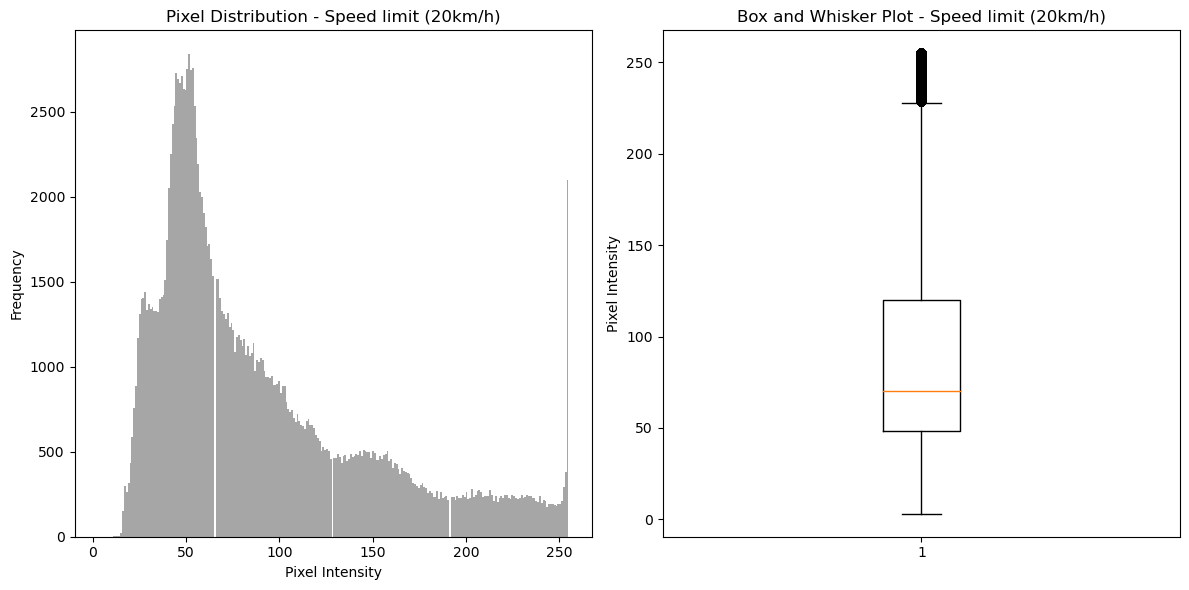

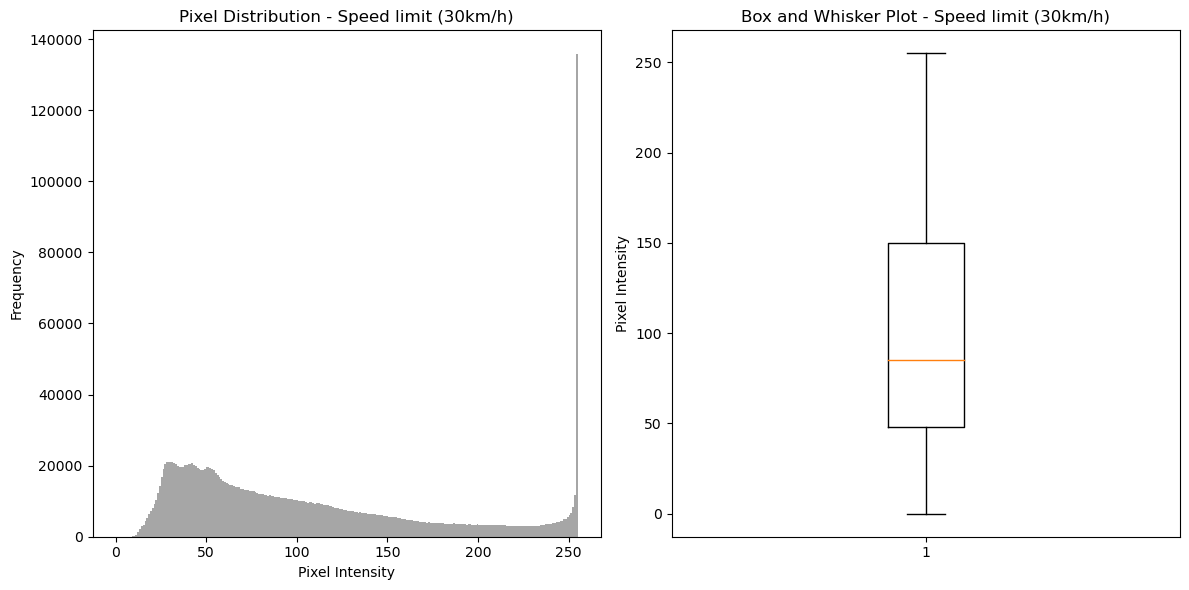

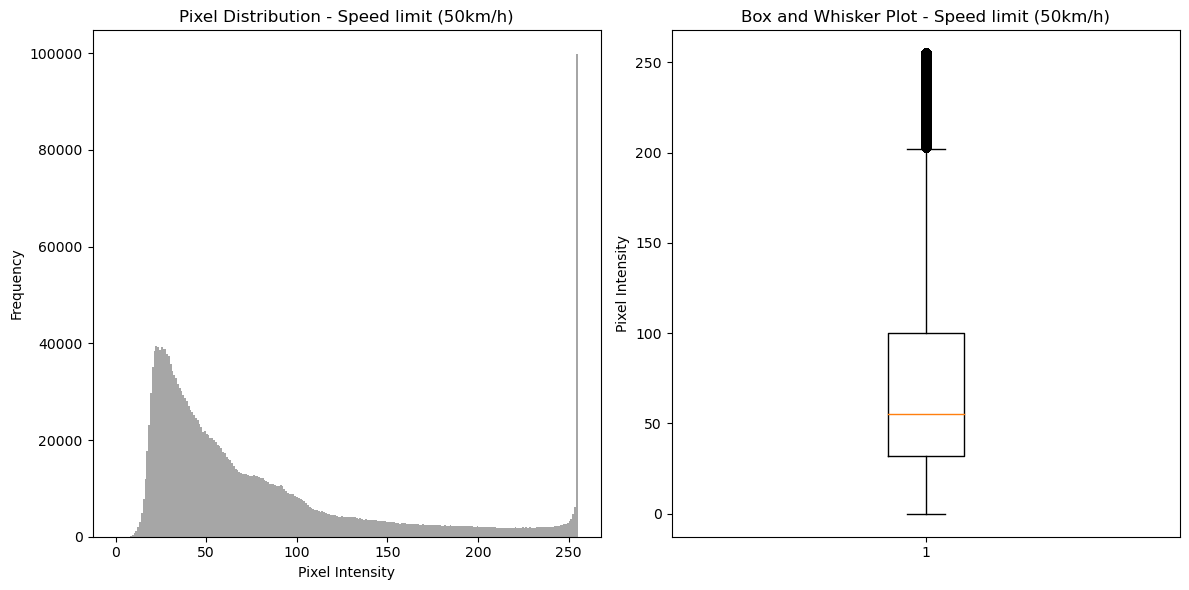

In [18]:
plot_pixel_distribution(train_images, train_labels, signnames, selected_labels=[0, 1, 2])

In [19]:
def plot_label_counts(labels, signnames, title=""):

    unique_labels, label_counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(label_counts)[::-1]  # Sort indices in descending order based on count

    sorted_labels = unique_labels[sorted_indices]
    sorted_counts = label_counts[sorted_indices]

    fig = plt.figure(figsize=(20, 16))
    plt.bar(range(len(sorted_labels)), sorted_counts)
    plt.xticks(range(len(sorted_labels)), [signnames[i] for i in sorted_labels], rotation='vertical')
    plt.title(f"Label Counts of {title} Data")
    plt.show()

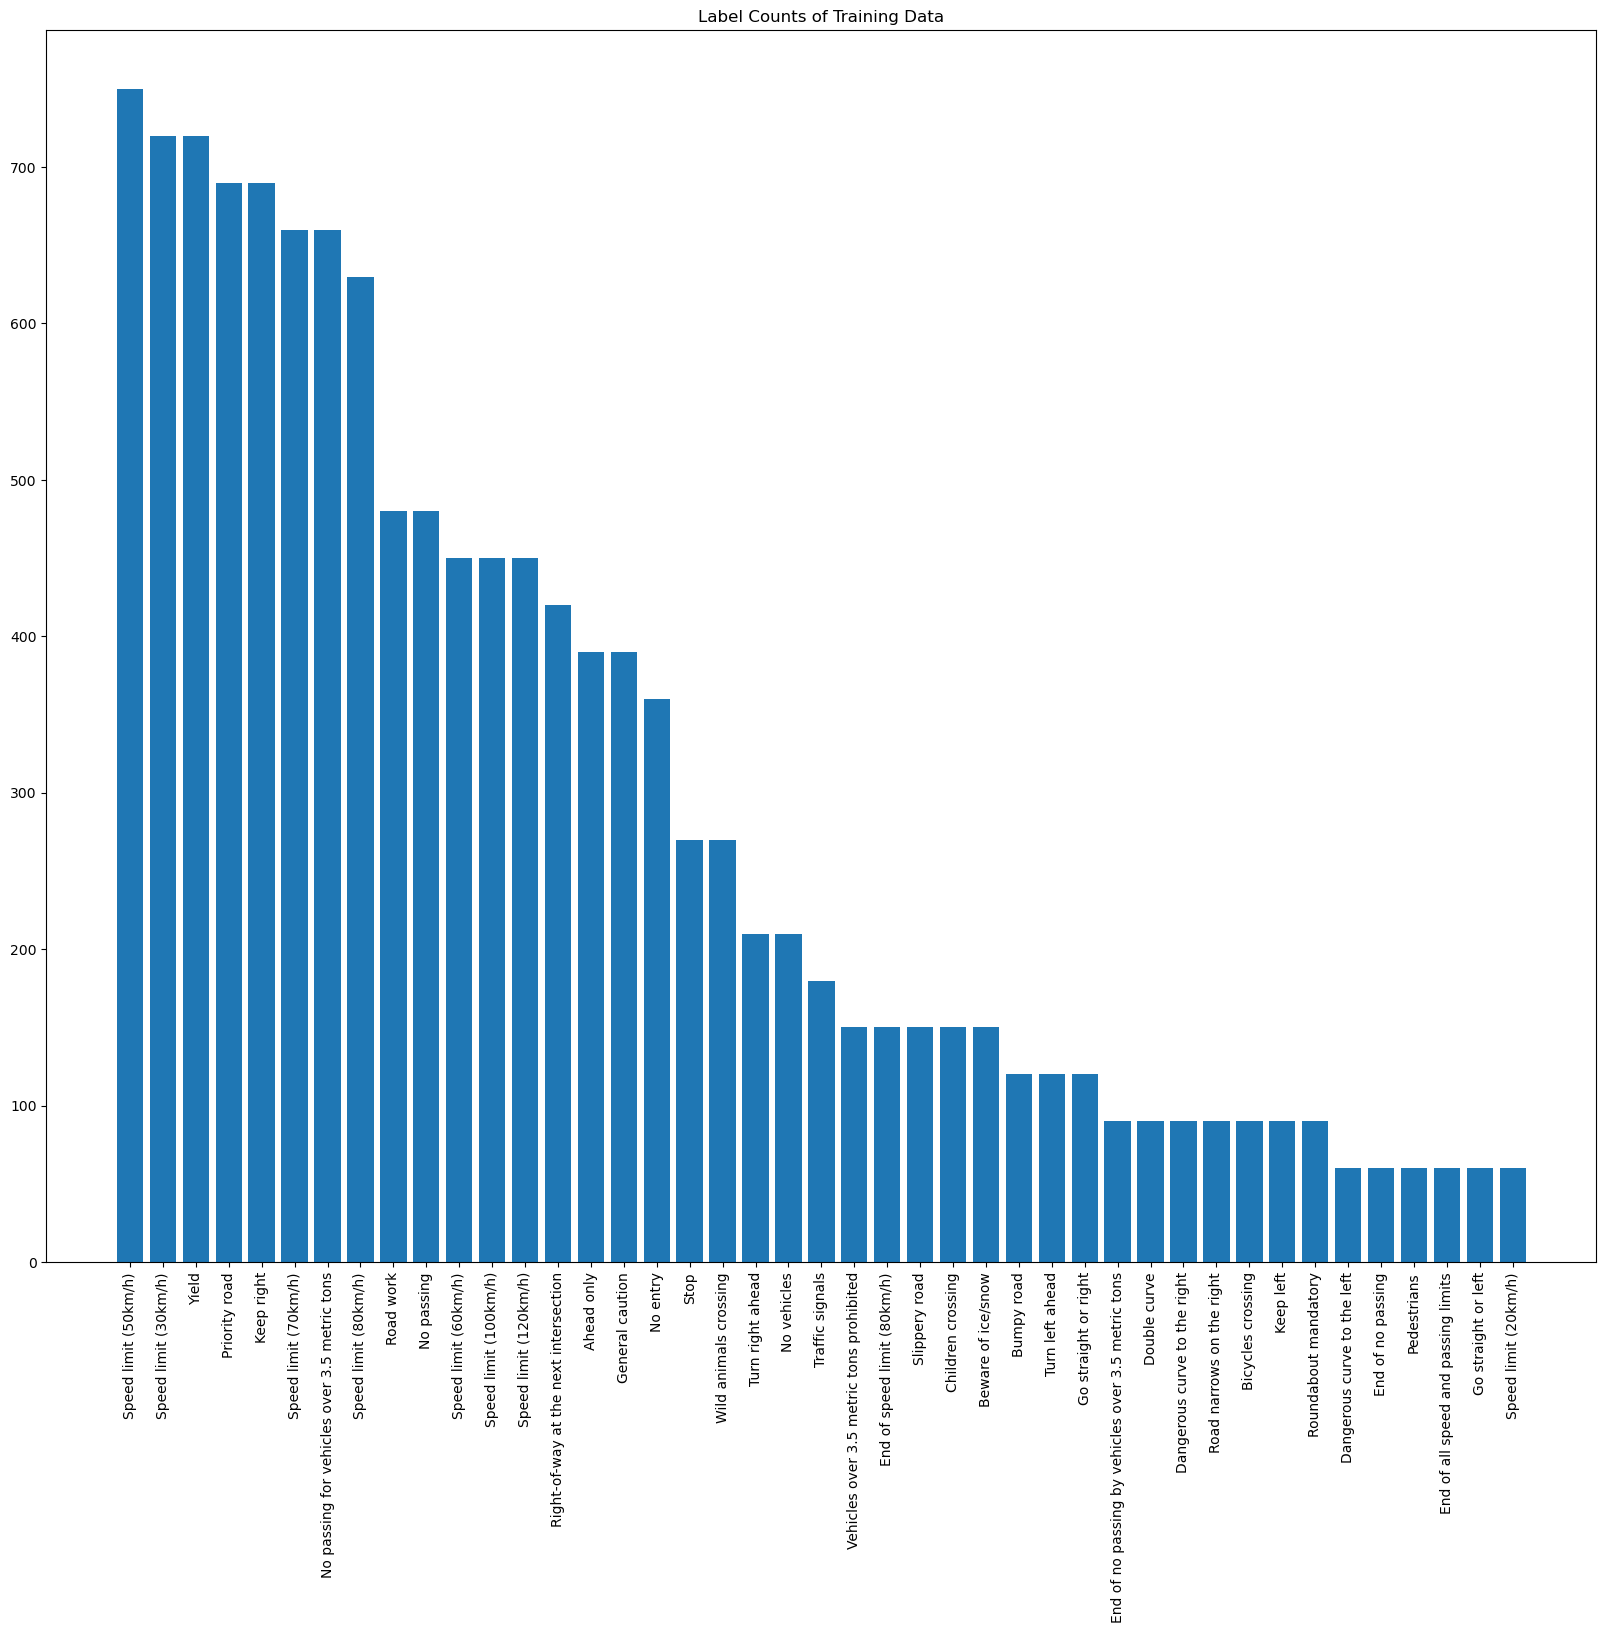

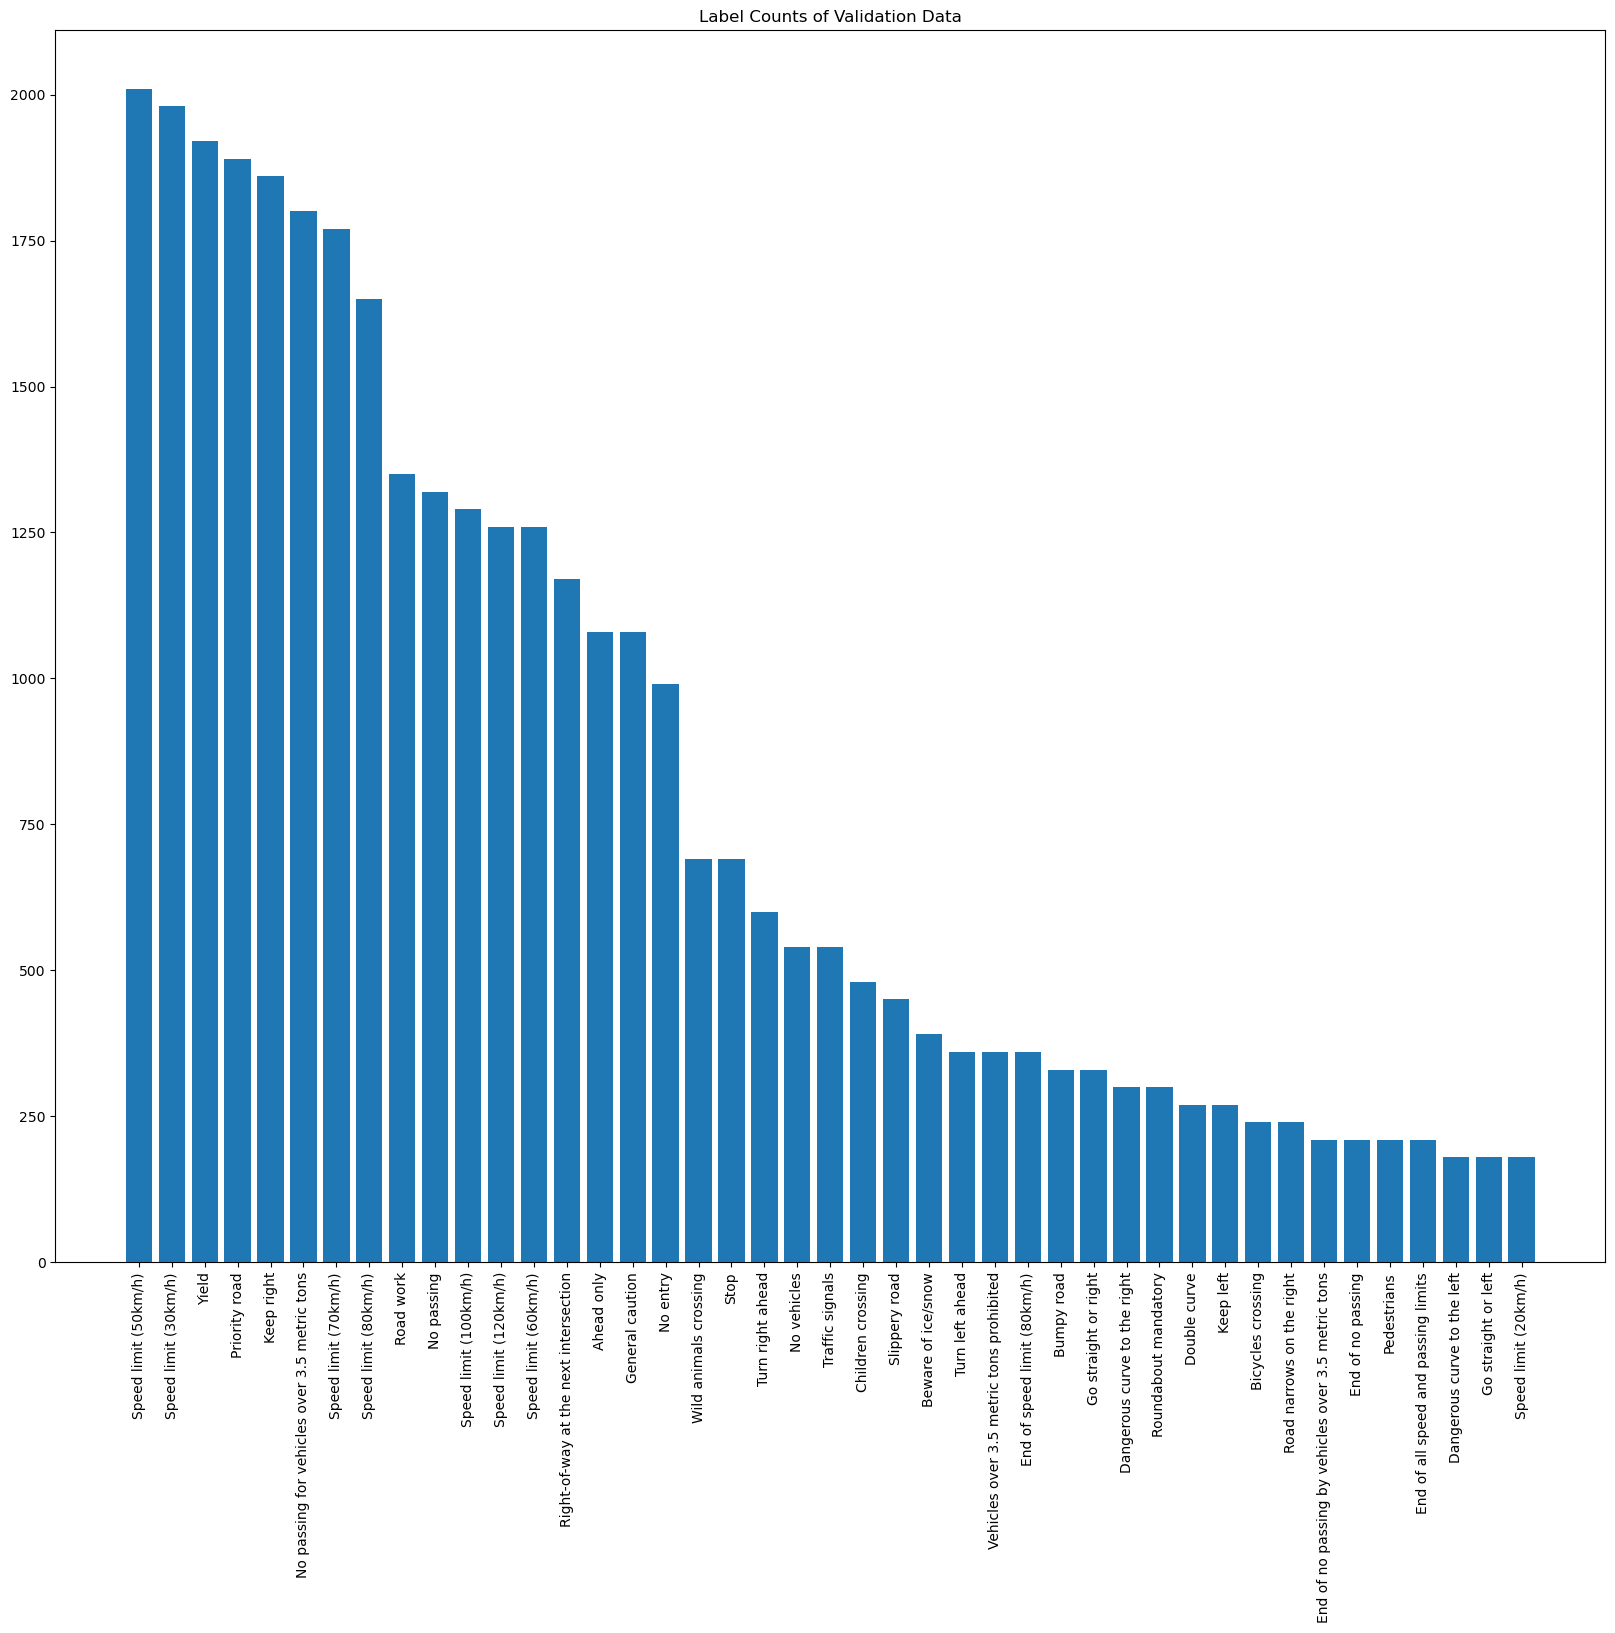

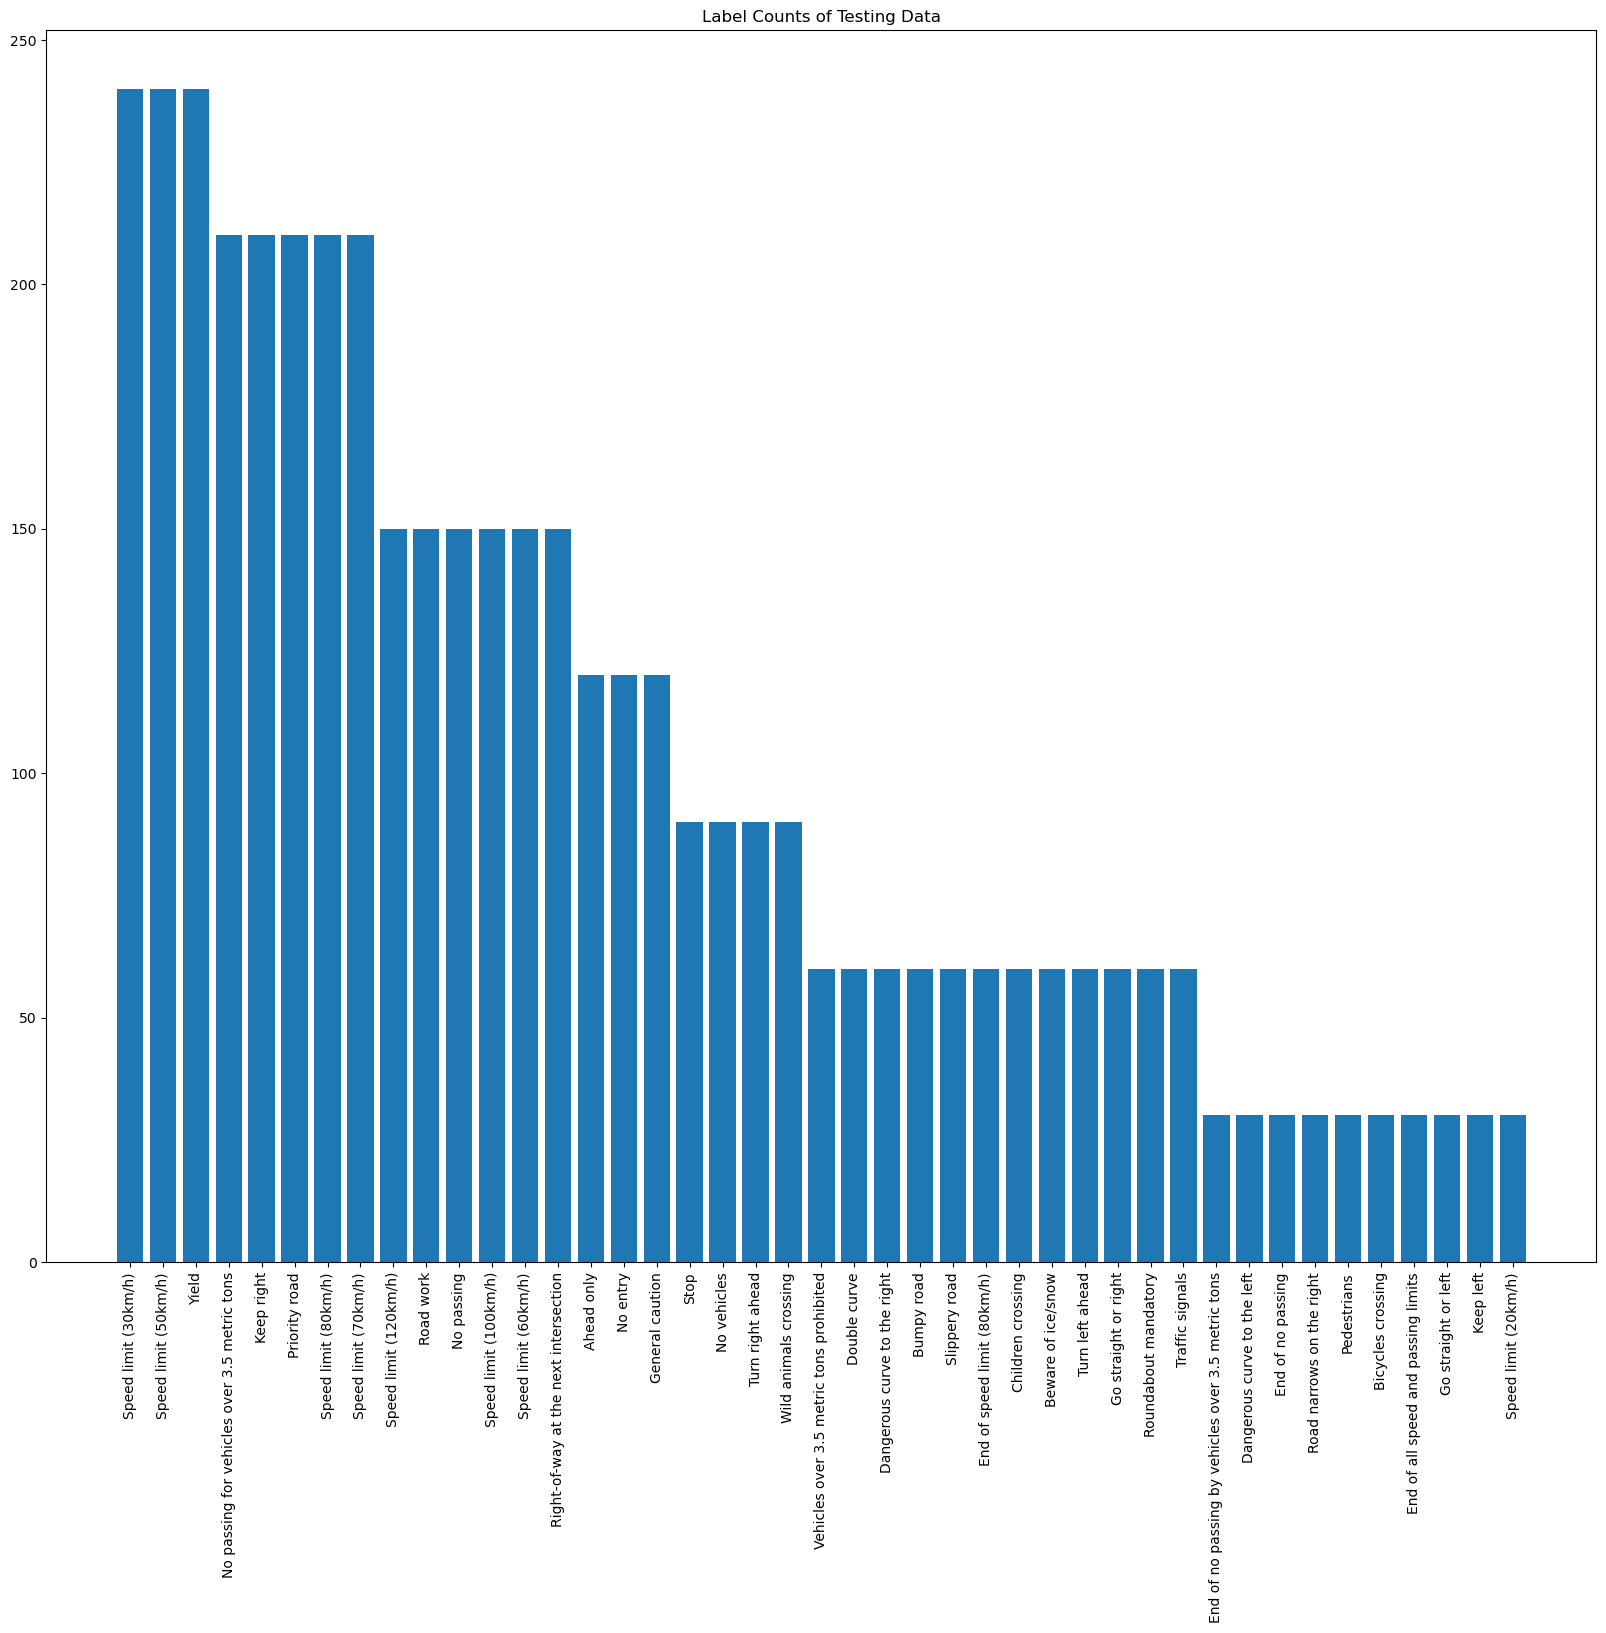

In [20]:
plot_label_counts(train_labels, signnames, "Training")
plot_label_counts(valid_labels, signnames, "Validation")
plot_label_counts(test_labels, signnames, "Testing")

## Data Preprocessing
- Shuffle the training data
- Grayscale the images
- Local Histogram Equalization
- Normalize the data

### Shuffle

In [21]:
def shuffle_data(images, labels):
    """
    Shuffles the data.

    Args:
        images (numpy.ndarray): An array of images.
        labels (numpy.ndarray): An array of labels.

    Returns:
        numpy.ndarray, numpy.ndarray: The shuffled images and labels.
    """
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    return images[indices], labels[indices]

In [22]:
# data before shuffling
print("Before shuffling: ", train_labels[:10])

# shuffle data
train_images, train_labels = shuffle_data(train_images, train_labels)

# data after shuffling
print("After shuffling: ", train_labels[:10])

Before shuffling:  [16  1 38 33 11 38 18 12 25 35]
After shuffling:  [11 10 14  2 16 40  5  4  3  8]


### Grayscale

In [23]:
def grayscale_images(images):
    """
    Converts images to grayscale.

    Args:
        images (numpy.ndarray): An array of images.

    Returns:
        numpy.ndarray: The grayscale images.
    """
    return cv2.cvtColor(images, cv2.COLOR_RGB2GRAY)

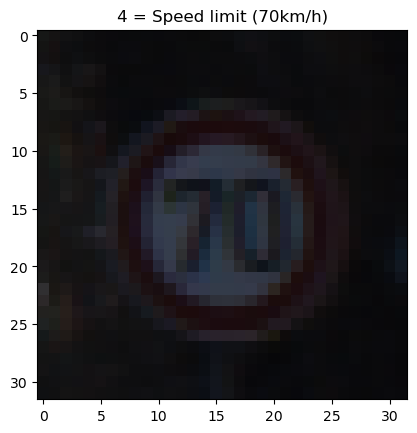

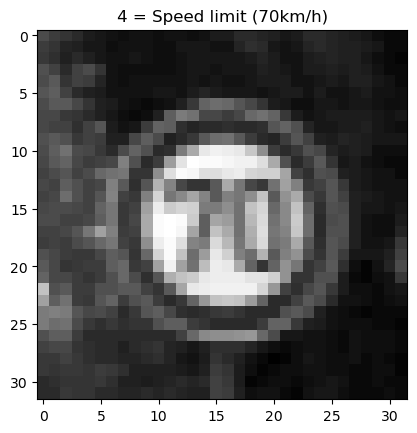

In [24]:
# sample image before grayscale
plot_image(train_images, train_labels, signnames, 10)

# grayscale image
gray_image = list(map(grayscale_images, train_images))

# sample image after grayscale
plot_image(gray_image, train_labels, signnames, 10, cmap='gray')

### Local Histogram Equalization

In [25]:
def equalize_images(images):
    """
    Apply local histogram equalization to grayscale images.

    Args:
        images (numpy.ndarray): An array of grayscale images.

    Returns:
        numpy.ndarray: The equalized images.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(images, selem=kernel)
    return img_local

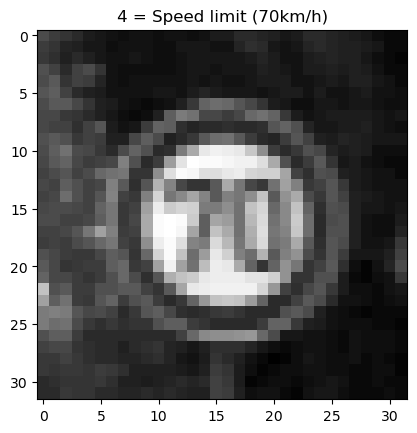

/tmp/ipykernel_32551/2208567284.py:12: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  img_local = rank.equalize(images, selem=kernel)


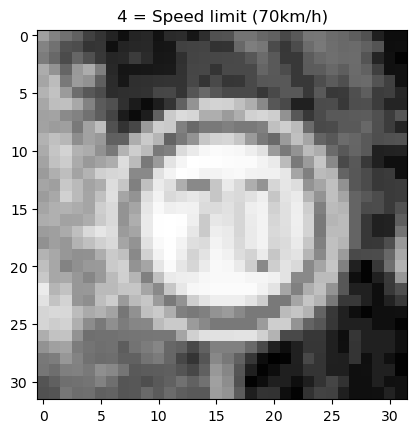

In [26]:
# sample image before equalization
plot_image(gray_image, train_labels, signnames, 10, cmap='gray')

# equalized image
equalized_image = list(map(equalize_images, gray_image))

# sample image after equalization
plot_image(equalized_image, train_labels, signnames, 10, cmap='gray')

### Normalize

In [27]:
def normalize_images(images):
    """
    Normalize images to [0, 1] scale.

    Args:
        images (numpy.ndarray): An array of images.

    Returns:
        numpy.ndarray: The normalized images.
    """
    # 0,255 -> 0,1
    return images / 255.0

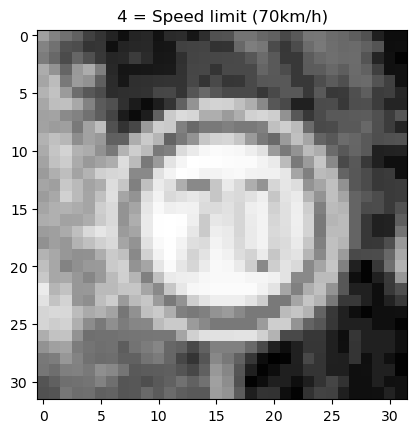

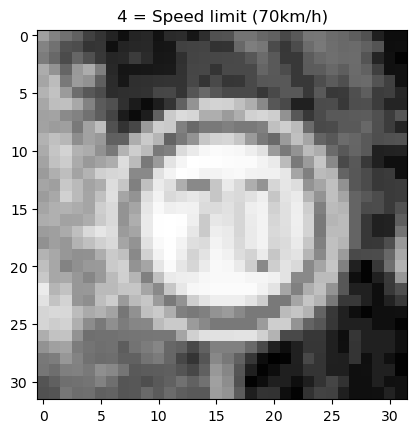

In [28]:
# sample image before normalization
plot_image(equalized_image, train_labels, signnames, 10, cmap='gray')

# normalized image
normalized_image = list(map(normalize_images, equalized_image))

# sample image after normalization
plot_image(normalized_image, train_labels, signnames, 10, cmap='gray')

In [29]:
def preprocess_data(images):
    """
    Preprocesses the data.

    Args:
        images (numpy.ndarray): An array of images.

    Returns:
        numpy.ndarray: The preprocessed images.
    """
    gray_images = list(map(grayscale_images, images))
    equalized_images = list(map(equalize_images, gray_images))
    n_shape= images.shape
    normalized_images = np.zeros((n_shape[0], n_shape[1], n_shape[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = normalize_images(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

In [30]:
# preprocess training data
train_images_P = preprocess_data(train_images)

# preprocess validation data
valid_images_P = preprocess_data(valid_images)

# preprocess testing data
test_images_P = preprocess_data(test_images)

/tmp/ipykernel_32551/2208567284.py:12: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  img_local = rank.equalize(images, selem=kernel)


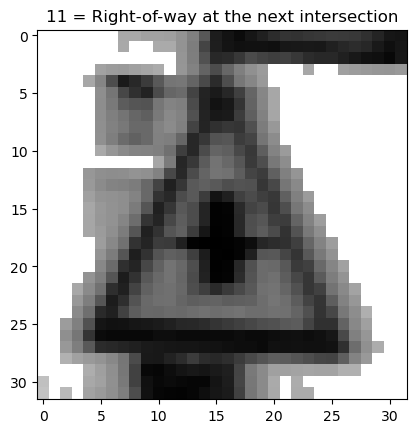

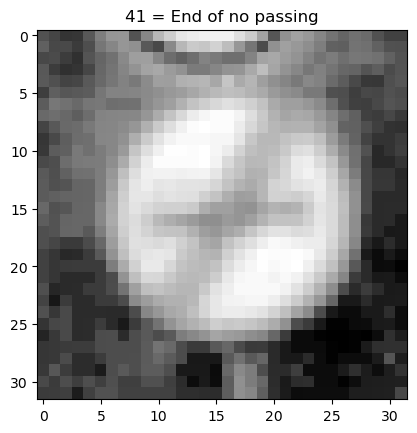

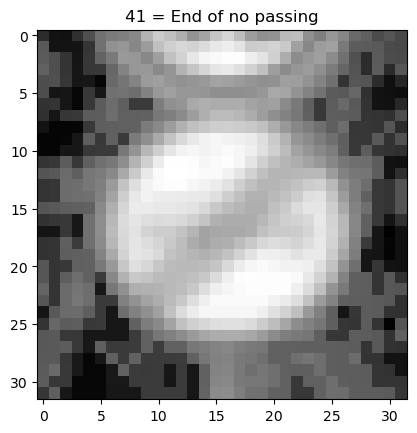

In [31]:
# sample image after preprocessing
plot_image(train_images_P, train_labels, signnames, 11, cmap='gray')
plot_image(valid_images_P, valid_labels, signnames, 11, cmap='gray')
plot_image(test_images_P, test_labels, signnames, 11, cmap='gray')

In [32]:
print("Shape of training images before preprocessing: ", train_images.shape)
print("Shape of training images after preprocessing: ", train_images_P.shape)
print()
print("Shape of validation images before preprocessing: ", valid_images.shape)
print("Shape of validation images after preprocessing: ", valid_images_P.shape)
print()
print("Shape of testing images before preprocessing: ", test_images.shape)
print("Shape of testing images after preprocessing: ", test_images_P.shape)

Shape of training images before preprocessing:  (12630, 32, 32, 3)
Shape of training images after preprocessing:  (12630, 32, 32, 1)

Shape of validation images before preprocessing:  (34799, 32, 32, 3)
Shape of validation images after preprocessing:  (34799, 32, 32, 1)

Shape of testing images before preprocessing:  (4410, 32, 32, 3)
Shape of testing images after preprocessing:  (4410, 32, 32, 1)


In [33]:
train_labels_P = tf.one_hot(train_labels, 43)
valid_labels_P = tf.one_hot(valid_labels, 43)
test_labels_P = tf.one_hot(test_labels, 43)

2023-07-02 18:53:49.040735: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-02 18:53:49.051576: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-02 18:53:49.052711: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-02 18:53:49.054848: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-02 18:53:49.055899: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not op

In [34]:
train_images_Pt = tf.convert_to_tensor(train_images_P, dtype=tf.float32)
valid_images_Pt = tf.convert_to_tensor(valid_images_P, dtype=tf.float32)
test_images_Pt = tf.convert_to_tensor(test_images_P, dtype=tf.float32)

In [35]:
print("Shape of training images: ", train_images_P.shape)
print("Shape of validation images: ", valid_images_P.shape)
print("Shape of testing images: ", test_images_P.shape)

print("Shape of training labels: ", train_labels_P.shape)
print("Shape of validation labels: ", valid_labels_P.shape)
print("Shape of testing labels: ", test_labels_P.shape)


Shape of training images:  (12630, 32, 32, 1)
Shape of validation images:  (34799, 32, 32, 1)
Shape of testing images:  (4410, 32, 32, 1)
Shape of training labels:  (12630, 43)
Shape of validation labels:  (34799, 43)
Shape of testing labels:  (4410, 43)


Not sure if we should return to removing outlier images or not-- think of a way to handle unbalanced classes.

## Model Architecture

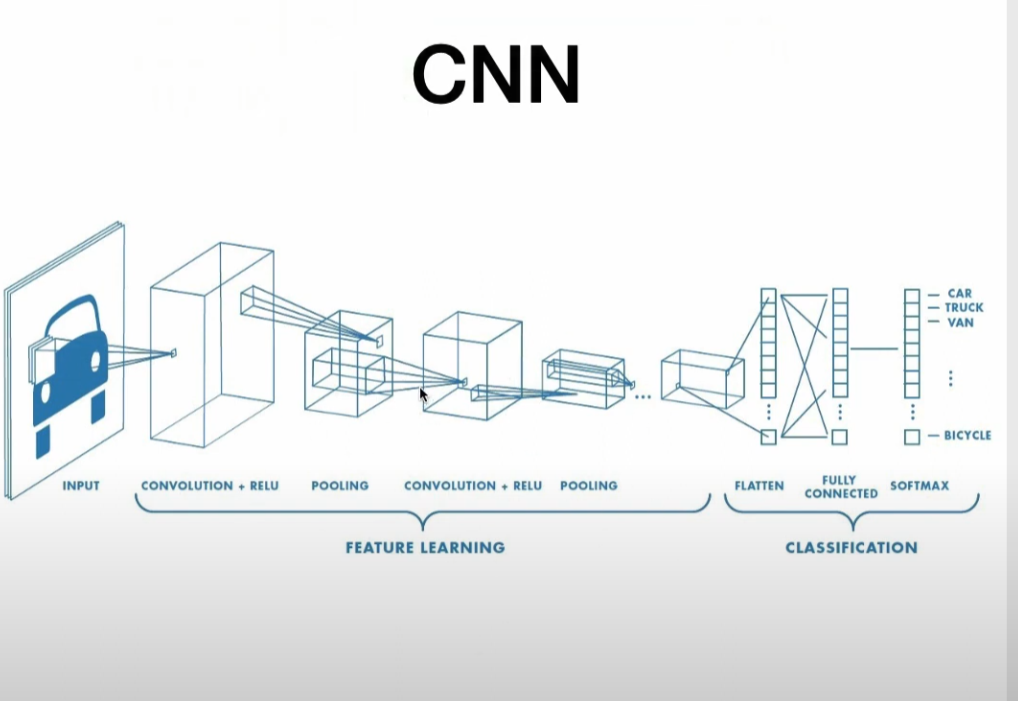

I will first implement my own CNN architecture and then compare it to the LeNet architecture.

Here's the architecture of my model:

Input => Convolution + ReLu => MaxPooling => Convolution + ReLu => MaxPooling => Flatten => Fully Connected (Dense) + ReLu => Fully Connected (Dense) + Softmax

**Layer 1: Convolutional.** The output shape should be 28x28x32.
**Activation.** ReLu activation function.
**Pooling.** The output shape should be 14x14x32.


In [36]:
def plot_accuracy_loss(model_history, model_name=""):
 
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Accuracy plot
    ax1.plot(model_history.history['categorical_accuracy'], color='tab:blue')
    ax1.plot(model_history.history['val_categorical_accuracy'], color='tab:orange')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim([0, 1])

    # Loss plot
    ax2 = ax1.twinx()
    ax2.plot(model_history.history['loss'], color='tab:green')
    ax2.plot(model_history.history['val_loss'], color='tab:red')
    ax2.set_ylabel('Loss')

    # Legend, title
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, ['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='lower left')
    plt.title('Accuracy and Loss for ' + model_name)
    plt.show()


In [37]:
# Define the model architecture
cnn_baseline = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=train_images_Pt.shape[1:]), # convulation layer + relu activation
    layers.MaxPooling2D((2, 2)), # max pooling layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), # convulation layer + relu activation 
    layers.MaxPooling2D((2, 2)),# max pooling layer

    layers.Flatten(), # flatten layer
    
    layers.Dense(64, activation='relu'), # fully connected layer + relu activation
    layers.Dense(43, activation='softmax')  # 43 classes
])

# configure parameters for the model
loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
cnn_baseline.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# print model summary
cnn_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                73792     
_________________________________________________________________
dense_1 (Dense)              (None, 43)                2

Epoch 1/30
198/198 [==============================] - 20s 75ms/step - loss: 3.2846 - categorical_accuracy: 0.1413 - val_loss: 1.6668 - val_categorical_accuracy: 0.5431
Epoch 2/30
198/198 [==============================] - 8s 38ms/step - loss: 1.0762 - categorical_accuracy: 0.6982 - val_loss: 1.0084 - val_categorical_accuracy: 0.7116
Epoch 3/30
198/198 [==============================] - 7s 37ms/step - loss: 0.4678 - categorical_accuracy: 0.8712 - val_loss: 0.8474 - val_categorical_accuracy: 0.7647
Epoch 4/30
198/198 [==============================] - 7s 37ms/step - loss: 0.2692 - categorical_accuracy: 0.9242 - val_loss: 0.7755 - val_categorical_accuracy: 0.7964
Epoch 5/30
198/198 [==============================] - 8s 38ms/step - loss: 0.1826 - categorical_accuracy: 0.9513 - val_loss: 0.8066 - val_categorical_accuracy: 0.7944
Epoch 6/30
198/198 [==============================] - 8s 38ms/step - loss: 0.1387 - categorical_accuracy: 0.9620 - val_loss: 0.8405 - val_categorical_accuracy: 0.79

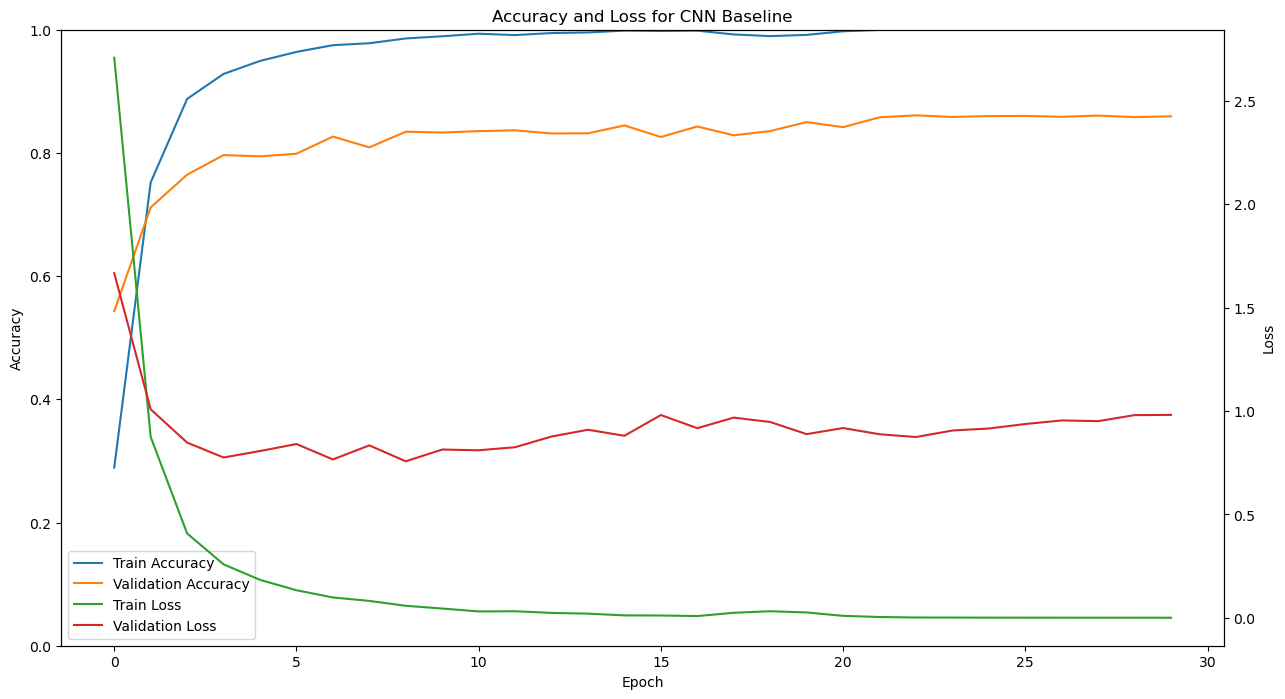

In [38]:
# fit / train the model
start_time = timeit.default_timer()

cnn_baseline_history = cnn_baseline.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=30, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {end_time - start_time} seconds")

plot_accuracy_loss(cnn_baseline_history, "CNN Baseline")


It appears that the model is overfitting the data.  I will try to see how the model performs with regularization and dropout layers to the model to see if that helps.

In [39]:
# Define the model architecture
cnn_regularized_dropout = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=(32, 32, 1)), # convulation layer + relu activation
    layers.MaxPooling2D((2, 2)), # max pooling layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), # convulation layer + relu activation 
    layers.MaxPooling2D((2, 2)),# max pooling layer

    layers.Flatten(), # flatten layer
    
    layers.Dense(64, activation='relu', kernel_regularizer = L2(0.001)), # L2 <- driving the parameters towards zero - decreases complexity
    layers.Dropout(0.5), # dropout layer - probability chance of dropping a neuron
    layers.Dense(43, activation='softmax')  # 43 classes
])

# configure parameters for the model
loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
cnn_regularized_dropout.compile(optimizer=optimizer, loss=loss, metrics=metrics)

cnn_regularized_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                73792     
_________________________________________________________________
dropout (Dropout)            (None, 64)               

Epoch 1/30
198/198 [==============================] - 8s 40ms/step - loss: 3.5798 - categorical_accuracy: 0.0770 - val_loss: 2.5081 - val_categorical_accuracy: 0.3955
Epoch 2/30
198/198 [==============================] - 8s 38ms/step - loss: 2.3199 - categorical_accuracy: 0.3678 - val_loss: 1.5711 - val_categorical_accuracy: 0.5994
Epoch 3/30
198/198 [==============================] - 8s 40ms/step - loss: 1.6673 - categorical_accuracy: 0.5160 - val_loss: 1.1112 - val_categorical_accuracy: 0.7129
Epoch 4/30
198/198 [==============================] - 8s 40ms/step - loss: 1.3860 - categorical_accuracy: 0.5834 - val_loss: 0.9905 - val_categorical_accuracy: 0.7544
Epoch 5/30
198/198 [==============================] - 7s 38ms/step - loss: 1.2232 - categorical_accuracy: 0.6296 - val_loss: 0.8790 - val_categorical_accuracy: 0.7623
Epoch 6/30
198/198 [==============================] - 8s 40ms/step - loss: 1.1262 - categorical_accuracy: 0.6560 - val_loss: 0.8127 - val_categorical_accuracy: 0.792

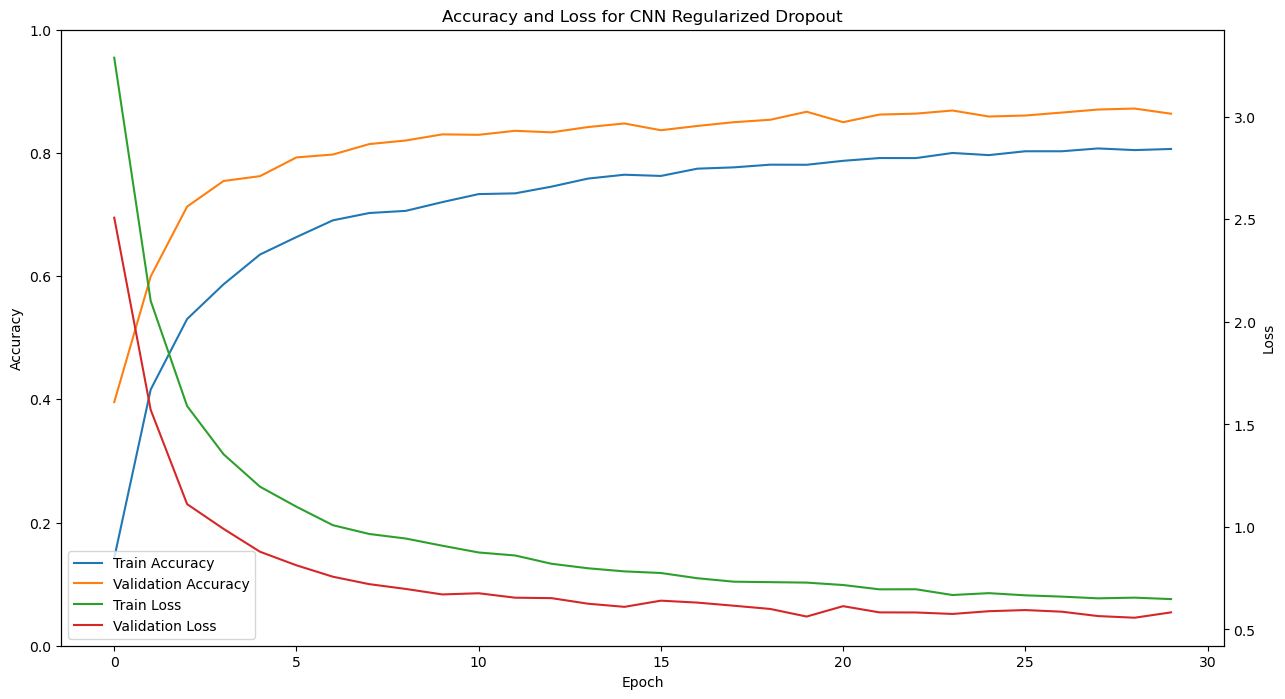

In [40]:
# fit / train the model
start_time = timeit.default_timer()

cnn_regularized_dropout_history = cnn_regularized_dropout.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=30, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {end_time - start_time} seconds")

plot_accuracy_loss(cnn_regularized_dropout_history, "CNN Regularized Dropout")

Let's try with Le-Net5 inspired architecture.

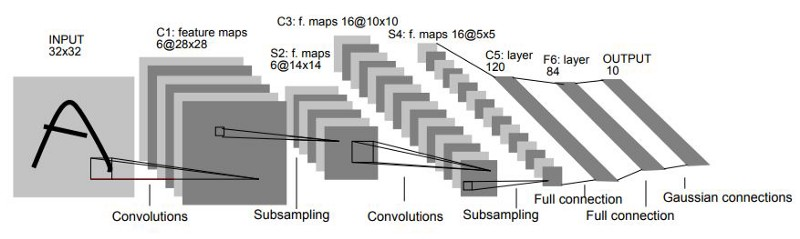

In [41]:
# Define the model architecture
lenet_baseline = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1,1), padding='valid', activation='relu', input_shape=(32, 32, 1)), # convulation layer + relu activation
    layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)), # average pooling layer
    layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1,1), activation='relu'), # convulation layer + relu activation 
    layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),# max pooling layer

    layers.Flatten(), # flatten layer
    
    layers.Dense(120, activation='relu'), # fully connected layer + relu activation
    layers.Dense(84, activation='relu'), # fully connected layer + relu activation
    layers.Dense(43, activation='softmax')  # 43 classes
])

loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
lenet_baseline.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(lenet_baseline.summary()) # see model architecture

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_5 (Dense)              (None, 84)               

Epoch 1/30
198/198 [==============================] - 16s 58ms/step - loss: 3.2501 - categorical_accuracy: 0.1547 - val_loss: 1.6754 - val_categorical_accuracy: 0.5228
Epoch 2/30
198/198 [==============================] - 6s 28ms/step - loss: 1.1763 - categorical_accuracy: 0.6495 - val_loss: 1.2084 - val_categorical_accuracy: 0.6605
Epoch 3/30
198/198 [==============================] - 6s 28ms/step - loss: 0.6715 - categorical_accuracy: 0.7953 - val_loss: 1.1868 - val_categorical_accuracy: 0.6863
Epoch 4/30
198/198 [==============================] - 5s 27ms/step - loss: 0.4461 - categorical_accuracy: 0.8690 - val_loss: 1.0150 - val_categorical_accuracy: 0.7450
Epoch 5/30
198/198 [==============================] - 5s 27ms/step - loss: 0.3210 - categorical_accuracy: 0.9066 - val_loss: 1.0764 - val_categorical_accuracy: 0.7406
Epoch 6/30
198/198 [==============================] - 5s 27ms/step - loss: 0.2479 - categorical_accuracy: 0.9297 - val_loss: 1.0209 - val_categorical_accuracy: 0.75

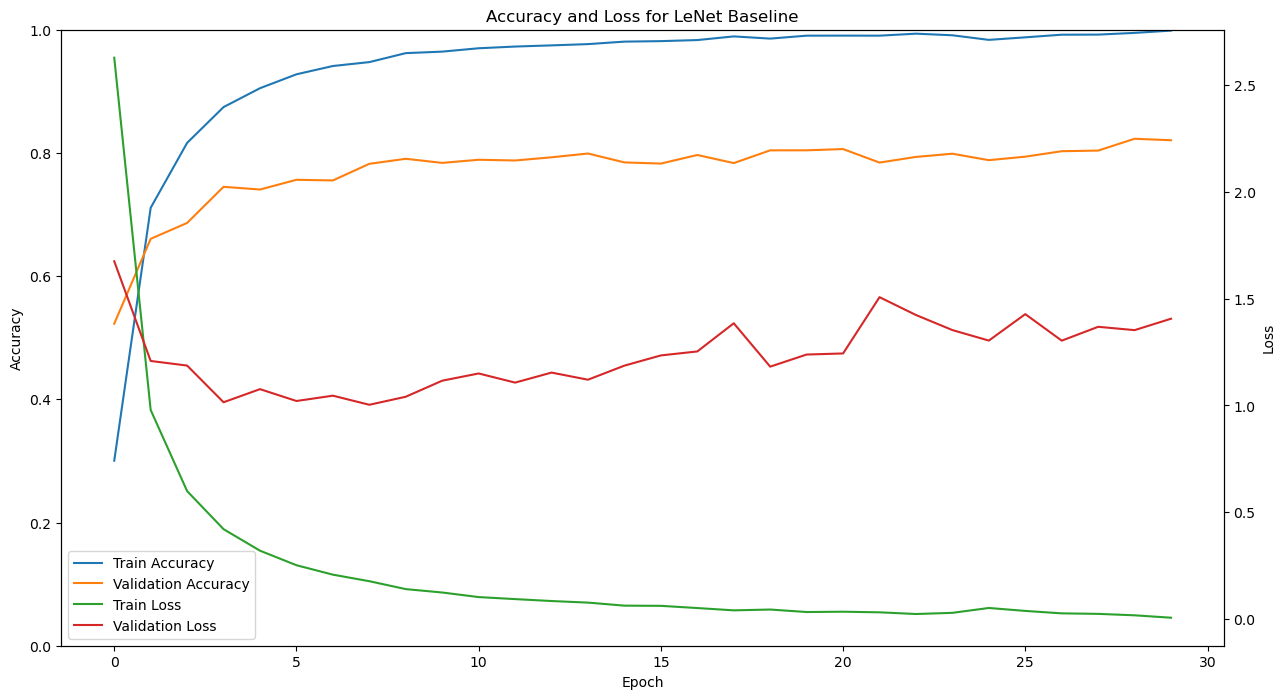

In [42]:
# fit / train the model
start_time = timeit.default_timer()

lenet_baseline_history = lenet_baseline.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=30, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {end_time - start_time} seconds")

plot_accuracy_loss(lenet_baseline_history, "LeNet Baseline")

This LeNet-5 architecture doesn't perform as well as our original model. Let's try to add dropout layers to the model to see if that helps.

In [43]:
# Define the model architecture
lenet_regularized_dropout = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1,1), padding='valid', activation='relu', input_shape=(32, 32, 1)), # convulation layer + relu activation
    layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)), # average pooling layer
    layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1,1), activation='relu'), # convulation layer + relu activation 
    layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),# max pooling layer

    layers.Flatten(), # flatten layer
    
    layers.Dense(120, activation='relu', kernel_regularizer = L2(0.001)), # L2 <- driving the parameters towards zero - decreases complexity
    layers.Dropout(0.5), # dropout layer - probability chance of dropping a neuron
    layers.Dense(84, activation='relu', kernel_regularizer = L2(0.001)), # L2 <- driving the parameters towards zero - decreases complexity
    layers.Dropout(0.5), # dropout layer - probability chance of dropping a neuron
    layers.Dense(43, activation='softmax')  # 43 classes
])

loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
lenet_regularized_dropout.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(lenet_regularized_dropout.summary()) # see model architecture

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               48120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)              

Epoch 1/30
198/198 [==============================] - 7s 31ms/step - loss: 3.7412 - categorical_accuracy: 0.0776 - val_loss: 2.6598 - val_categorical_accuracy: 0.3721
Epoch 2/30
198/198 [==============================] - 6s 30ms/step - loss: 2.6057 - categorical_accuracy: 0.3039 - val_loss: 1.7238 - val_categorical_accuracy: 0.5591
Epoch 3/30
198/198 [==============================] - 6s 30ms/step - loss: 1.8665 - categorical_accuracy: 0.4883 - val_loss: 1.3238 - val_categorical_accuracy: 0.6551
Epoch 4/30
198/198 [==============================] - 6s 30ms/step - loss: 1.5323 - categorical_accuracy: 0.5742 - val_loss: 1.1119 - val_categorical_accuracy: 0.7267
Epoch 5/30
198/198 [==============================] - 6s 30ms/step - loss: 1.2965 - categorical_accuracy: 0.6500 - val_loss: 1.0105 - val_categorical_accuracy: 0.7582
Epoch 6/30
198/198 [==============================] - 6s 28ms/step - loss: 1.1677 - categorical_accuracy: 0.6887 - val_loss: 0.9519 - val_categorical_accuracy: 0.767

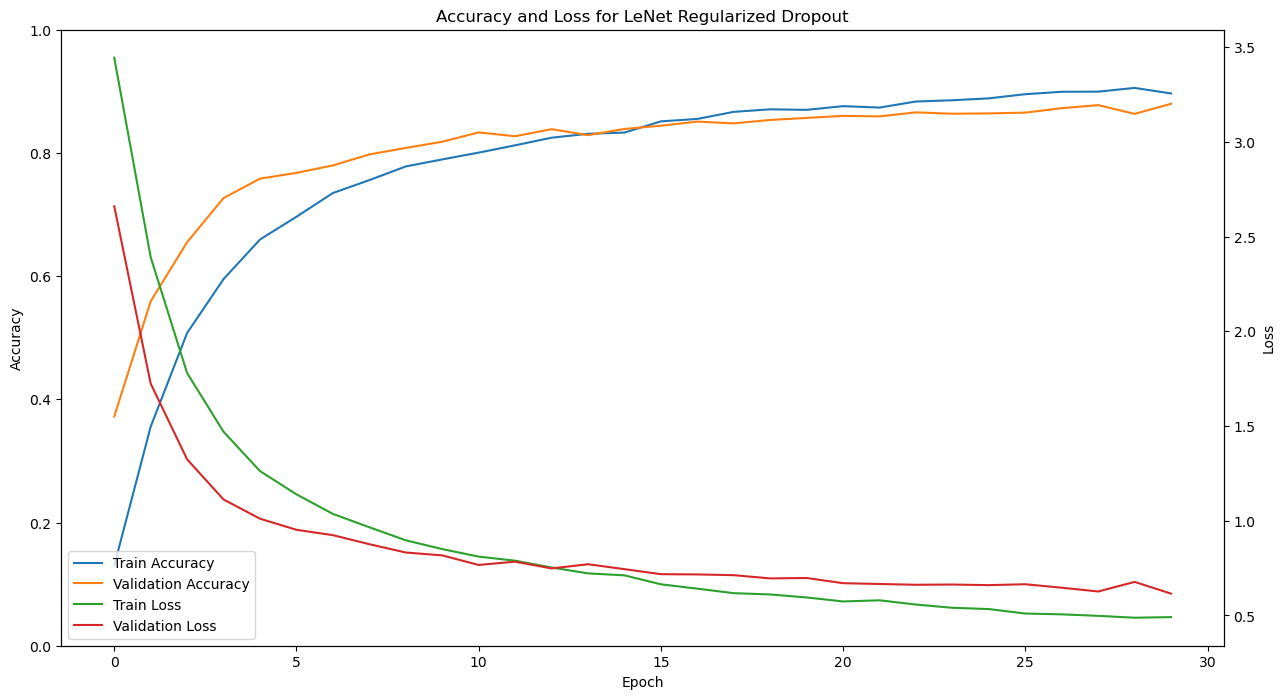

In [44]:
# fit / train the model
start_time = timeit.default_timer()

lenet_regularized_dropout_history = lenet_regularized_dropout.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=30, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {end_time - start_time} seconds")

plot_accuracy_loss(lenet_regularized_dropout_history, "LeNet Regularized Dropout")

It appears our initially CNN model still outperforms the LeNet-5 model.  Let's save this model and then evaluate it on the test set.

In [45]:
print("STOP")

STOP


In [46]:
# save all the models
#cnn_baseline.save('cnn_baseline')
#cnn_regularized_dropout.save('cnn_regularized_dropout')
#lenet_baseline.save('lenet_baseline')
#lenet_regularized_dropout.save('lenet_regularized_dropout')

In [51]:
# run evaluation on the cnn_regularized_dropout model
test_prediction = cnn_regularized_dropout.evaluate(test_images_Pt, test_labels_P)

138/138 [==============================] - 6s 25ms/step - loss: 0.6166 - categorical_accuracy: 0.8583


In [52]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_pred_labels = np.argmax(test_prediction, axis=1)

confusion_mat = confusion_matrix(test_labels_P, test_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
c

In [49]:
# 1) Save whole model
# SavedModel or HDF5 (Hierarchical Data Format)
#model.save('traffic_signs_model_initial')

# 2) Save only weights
#model.save_weights('traffic_signs_model_weights_initial')

# 3) Save only architecture
'''
model_arch = model.to_json()
with open('traffic_signs_model_architecture_initial.json', 'w') as f:
    f.write(model_arch)
with open('traffic_signs_model_architecture_initial.json', 'r') as f:
    model_architecture = f.read()

new_model = keras.models.model_from_json(model_architecture)
# this will only load the architecture and not the weights

new_model = keras.models.load_model('traffic_signs_model_initial')
new_model.evaluate(test_images_P, test_labels, verbose=2)
'''

"\nmodel_arch = model.to_json()\nwith open('traffic_signs_model_architecture_initial.json', 'w') as f:\n    f.write(model_arch)\nwith open('traffic_signs_model_architecture_initial.json', 'r') as f:\n    model_architecture = f.read()\n\nnew_model = keras.models.model_from_json(model_architecture)\n# this will only load the architecture and not the weights\n\nnew_model = keras.models.load_model('traffic_signs_model_initial')\nnew_model.evaluate(test_images_P, test_labels, verbose=2)\n"